In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = 'svg'

Using TensorFlow backend.


## LSTM

In [4]:
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm


def denormalize(test_y, df, predict_target="3_day_return"):
    return test_y * (np.max(df[predict_target]) - np.min(df[predict_target])) + np.mean(
        df[predict_target]
    )


def train_(df, ref_day=5, predict_day=1, predict_target="3_day_return"):
    X_train, Y_train = [], []
    for i in range(df.shape[0] - predict_day - ref_day):
        X_train.append(np.array(df.iloc[i : i + ref_day, df.columns != predict_target]))
        Y_train.append(
            np.array(df.iloc[i + ref_day : i + ref_day + predict_day][predict_target])
        )
    return np.array(X_train), np.array(Y_train)


def get_train_test(X, Y, split_boundary):
    train_x = X[:split_boundary]
    test_x = X[split_boundary:]
    train_y = Y[:split_boundary]
    test_y = Y[split_boundary:]
    return train_x, test_x, train_y, test_y


def get_model(train_x):
    model = Sequential()
    model.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(train_x.shape[1], train_x.shape[2]),
        )
    )
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

    return model


def train(df, title=None, split_boundary=2110, predict_target="3_day_return"):

    norm_df = normalize(df)

    # 7 days predict 1 day
    X, Y = train_(norm_df, 7, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    es = EarlyStopping(monitor="loss", patience=100, verbose=0, mode="min")
    history = model.fit(
        train_x, train_y, epochs=1000, batch_size=128, verbose=0, callbacks=[es]
    )

    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(
        go.Scatter(y=history.history["loss"], name="training loss"), row=1, col=1
    )

    score = model.evaluate(test_x, test_y, verbose=0)
    predict_y = model.predict(test_x)
    #     norm_mse = mean_squared_error(test_y, predict_y)
    test_y_list = denormalize(test_y, df, predict_target).ravel()
    predict_y_list = denormalize(predict_y, df, predict_target).ravel()
    mean = np.mean(np.abs(np.array(predict_y_list) - np.array(test_y_list)))

    fig.add_trace(
        go.Scatter(y=test_y_list, mode="lines", name="actual return"), row=2, col=1
    )
    fig.add_trace(
        go.Scatter(y=predict_y_list, mode="lines", name="predict return"), row=2, col=1
    )
    fig.update_layout(
        title_text="Crops : {}, Loss : {}, Mean: {}".format(title, score[0], mean),
    )
    fig.show()
    return test_y_list, predict_y_list


crops_arr = [
    "香蕉",
    "洋香瓜-網狀紅肉",
    "蓮霧-紅蓮霧",
    "鳳梨-金鑽鳳梨",
    "南瓜-木瓜形",
    "大蒜-蒜瓣",
    "青蔥-日蔥",
    "小白菜-土白菜",
    "芽菜類-黃豆牙",
    "木瓜-網室紅肉",
]


## Predict without feature selection

### 1 day return

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



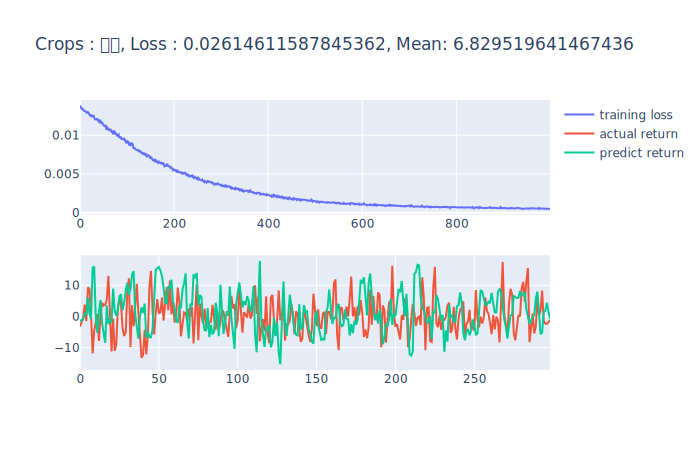

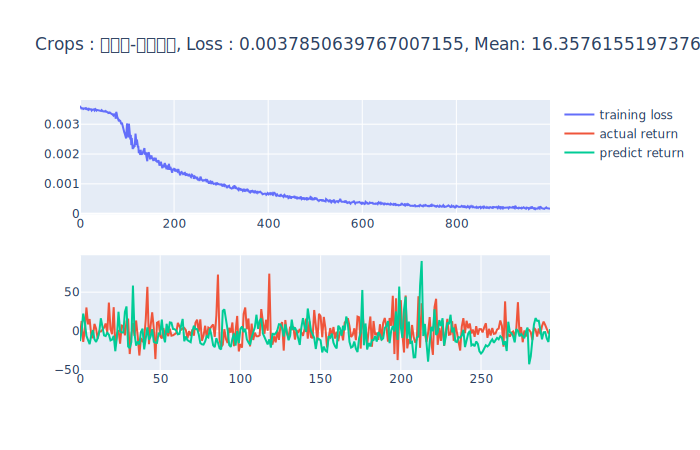

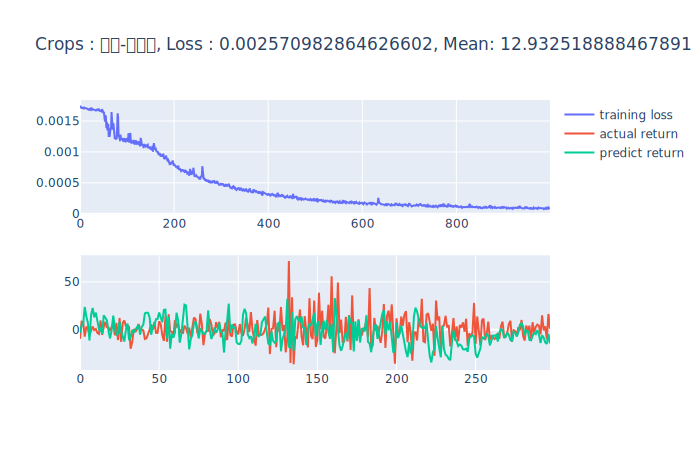

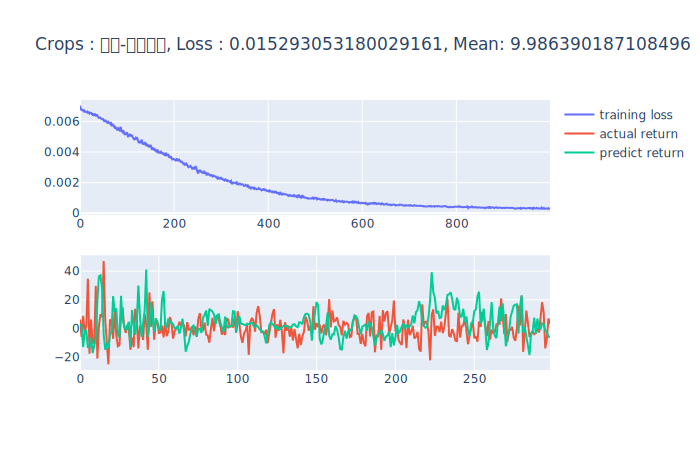

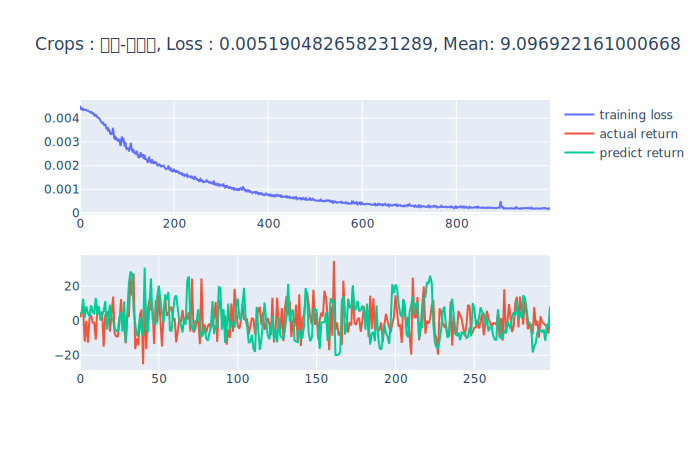

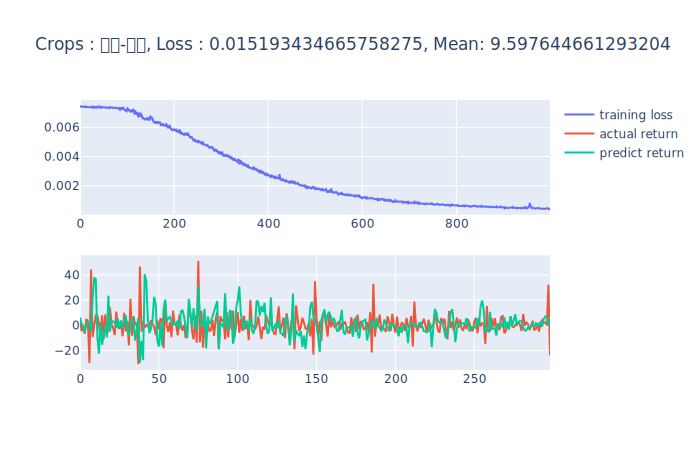

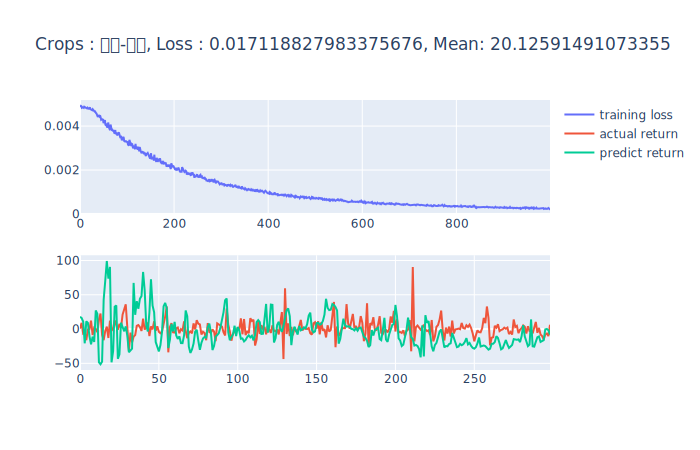

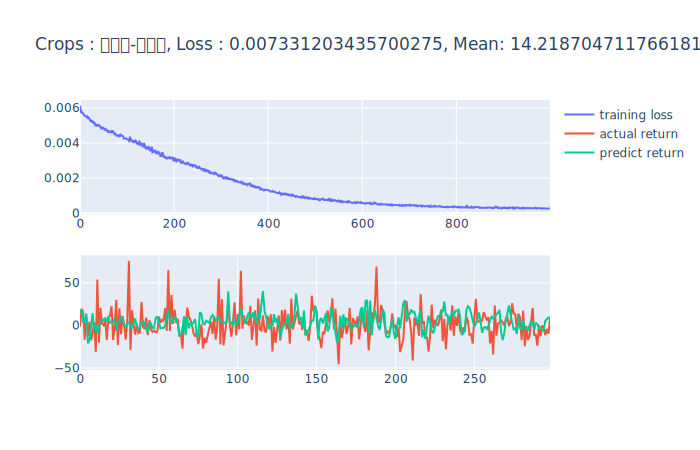

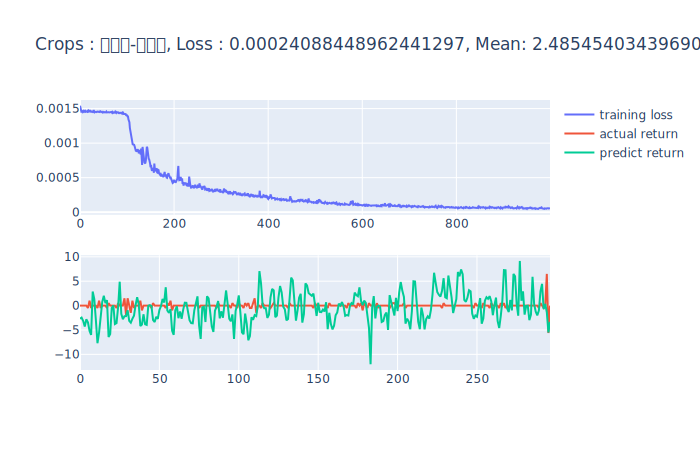

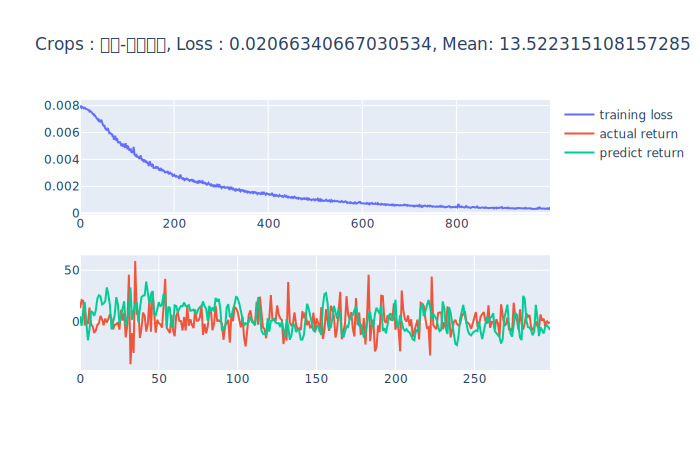

In [3]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list = train(
        df.drop(columns=["DateTime", "Year", "Day", "3_day_return", "5_day_return"]),
        crops,
        split_boundary - 8,
        "1_day_return",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_1_day_return.csv".format(crops), index=False, encoding="utf_8_sig")



### 3 days return

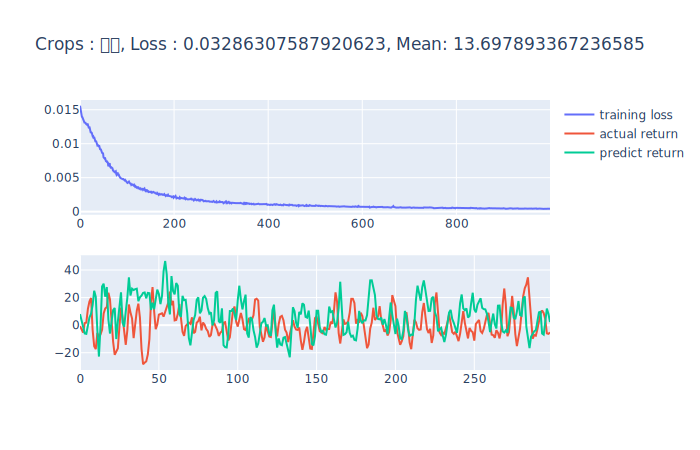

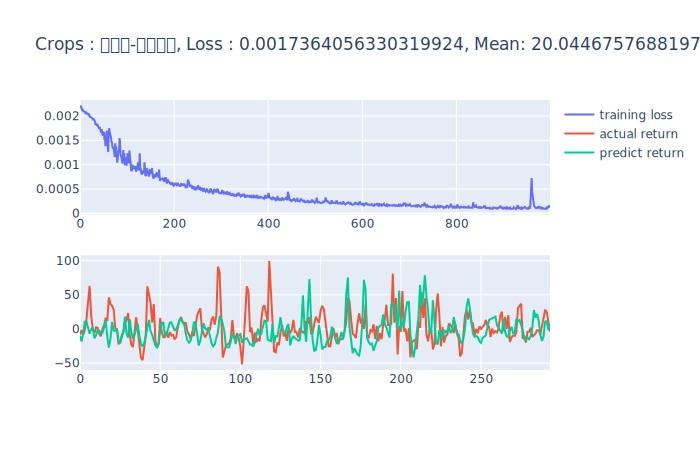

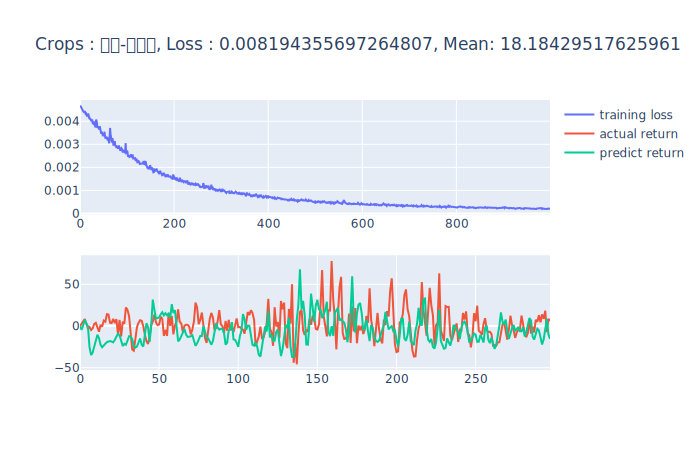

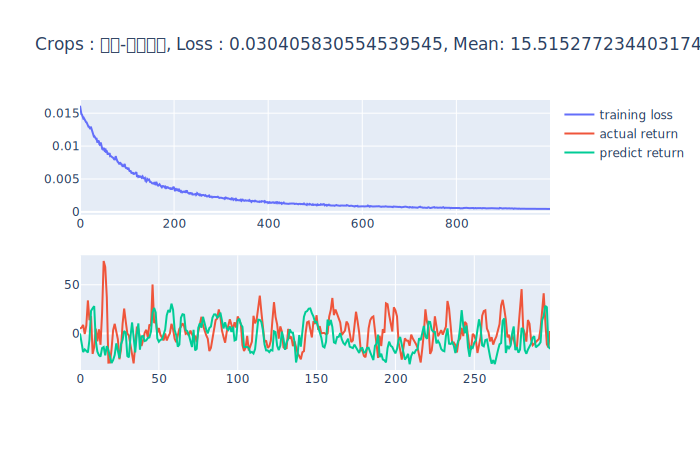

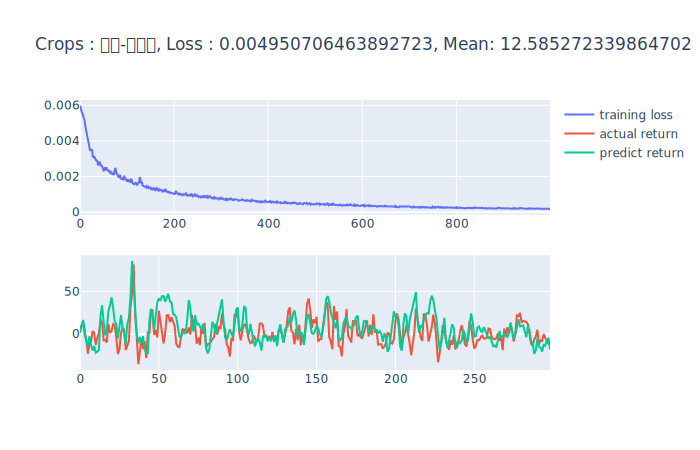

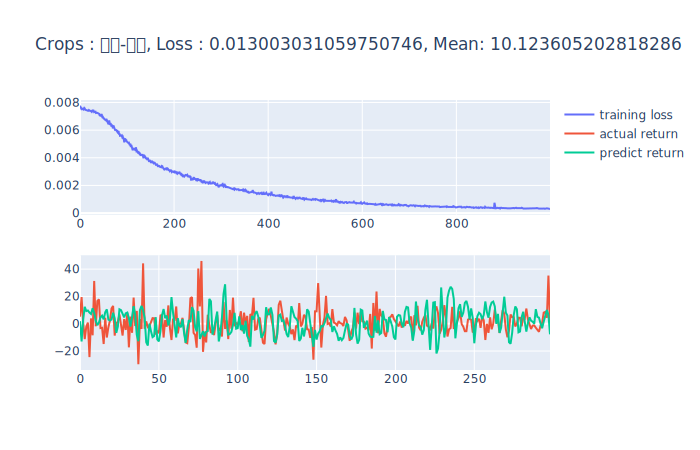

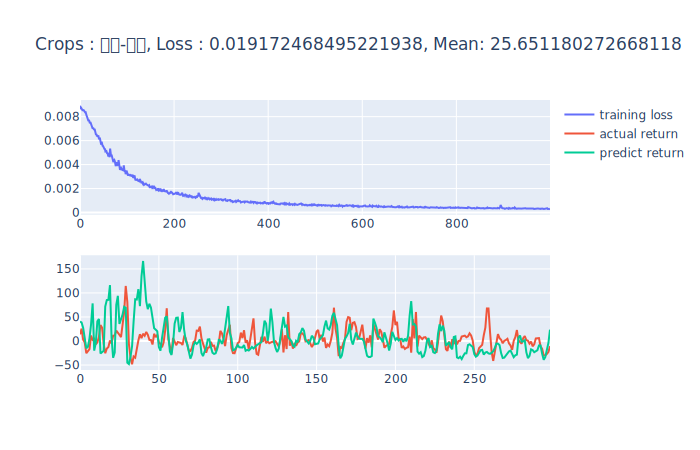

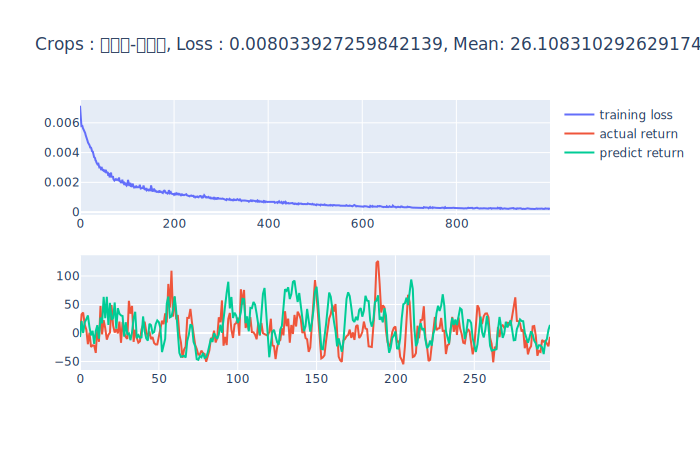

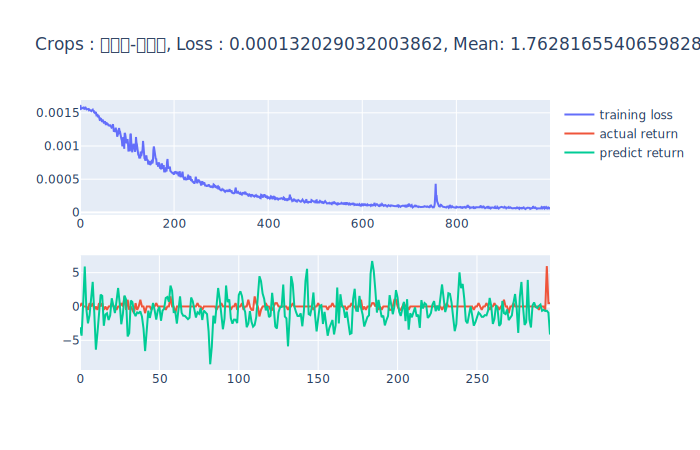

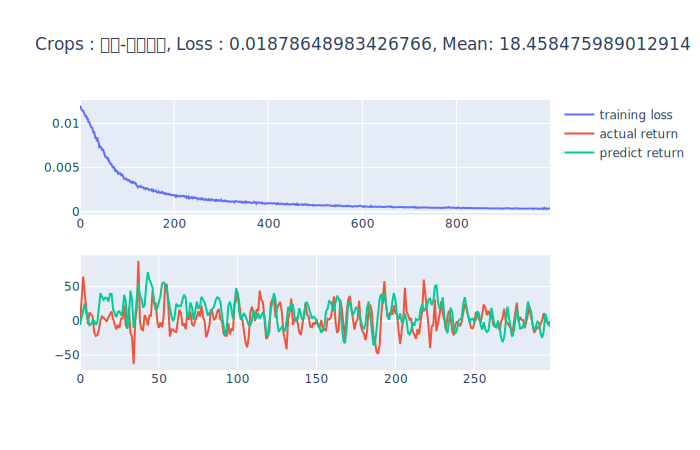

In [4]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    test_y_list, predict_y_list = train(
        df.drop(columns=["DateTime", "Year", "Day", "1_day_return", "5_day_return"]),
        crops,
        split_boundary - 8,
        "3_day_return",
    )
    data = {
        "DateTime": df["DateTime"][split_boundary:],
        "Original": test_y_list,
        "Predict": predict_y_list,
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_3_day_return.csv".format(crops), index=False, encoding="utf_8_sig")



## Predict with feature selection
### select top 10 features of each input ( total 7 days input ) and np.unique

In [4]:
predict_target = "3_day_return"
df = pd.read_csv("../data/{}.csv".format(crops_arr[0]))
split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
df = df.drop(columns=["DateTime", "Year", "Day", "1_day_return", "5_day_return"])
norm_df = normalize(df)
X, Y = train_(norm_df, 7, 1, predict_target)
train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

model = get_model(train_x)
explainer = shap.DeepExplainer(model, train_x)
shap_values = explainer.shap_values(test_x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



keras is no longer supported, please use tf.keras instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
shap.summary_plot(
    shap_values[0][:, 0, :],
    norm_df[split_boundary + 8 :].drop(columns=["3_day_return"]),
    max_display=10,
)

NameError: name 'shap' is not defined

In [5]:
import shap

shap.initjs()

def get_important_feature(df, split_boundary, predict_target="3_day_return"):
    norm_df = normalize(df)
    X, Y = train_(norm_df, 7, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    explainer = shap.GradientExplainer(model, train_x)
    shap_values = explainer.shap_values(test_x)

    feature_index_arr = []

    for i in range(7):
        feature_index_arr.append(
            np.flip(np.argsort(np.abs(shap_values[0]).mean(0))[i])[0:20]
        )
    feature_index = np.unique(feature_index_arr)
    
    # check return in df
    if 2 not in feature_index:
        feature_index = np.concatenate([[2], feature_index])

    return df.iloc[:, feature_index]


### 1 day return

feature selection : Index(['Month', '平均價', '1_day_return', 'C0A530_Precp', '467490_StnPres',
       '467420_Temperature', '467440_StnPres', '467440_Temperature',
       'C0C590_StnPres', 'C0C590_Precp', 'C0D560_StnPres', 'C0D560_Precp',
       'C0E750_StnPres', 'C0H950_StnPres', 'C0H950_Temperature',
       'C0H950_Precp', 'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_Precp',
       '467480_Precp', '467590_StnPres', '467590_Temperature', '467590_WS',
       '467590_Precp', 'C0Z061_StnPres', 'C0Z061_Temperature',
       '467660_StnPres'],
      dtype='object')


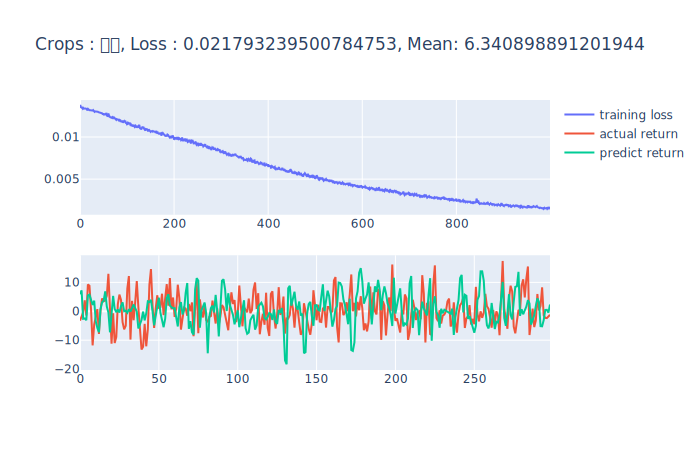

feature selection : Index(['1_day_return', 'C0A530_Temperature', '467420_StnPres', '467420_WS',
       '467420_WSGust', '467440_StnPres', 'C0C590_StnPres',
       'C0C590_Temperature', 'C0C590_Precp', 'C0D560_StnPres', 'C0D560_Precp',
       'C0E750_Temperature', 'C0E750_Precp', 'C0H950_StnPres',
       'C0G660_StnPres', 'C0G660_Temperature', 'C0G660_WS',
       'C0K240_Temperature', 'C0K240_WS', 'C0K240_Precp', '467480_Precp',
       '467590_Temperature', '467590_WS', '467080_StnPres', 'C0Z061_StnPres',
       'C0Z061_WS', 'C0Z061_Precp'],
      dtype='object')


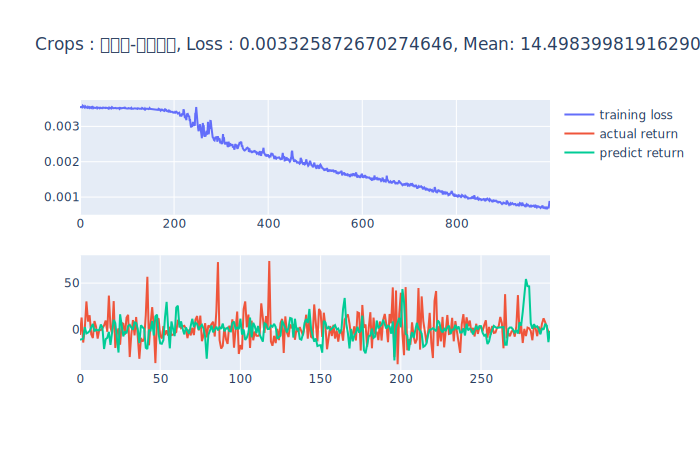

feature selection : Index(['1_day_return', 'C0A530_Precp', '467490_StnPres', '467490_Temperature',
       '467440_StnPres', 'C0C590_StnPres', 'C0C590_Temperature',
       'C0C590_Precp', 'C0D560_StnPres', 'C0D560_Temperature', 'C0D560_Precp',
       'C0E750_WS', 'C0E750_Precp', 'C0G660_StnPres', 'C0G660_Temperature',
       'C0G660_WS', 'C0G660_Precp', 'C0K240_StnPres', 'C0K240_Precp',
       '467480_StnPres', '467480_Temperature', '467480_Precp', '467590_WS',
       '467080_StnPres', '467080_Temperature', 'C0Z061_StnPres'],
      dtype='object')


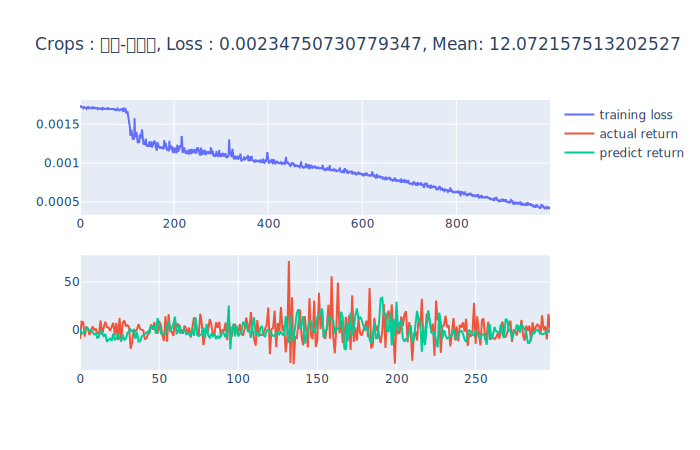

feature selection : Index(['Month', '1_day_return', '交易量', '強度', 'C0A530_StnPres',
       'C0A530_Temperature', 'C0A530_WS', '467490_Temperature', '467490_WS',
       '467420_Temperature', '467420_Precp', 'C0C590_StnPres',
       'C0D560_StnPres', 'C0D560_Temperature', 'C0D560_WS', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_WS', 'C0H950_Temperature',
       'C0G660_Temperature', 'C0G660_WS', 'C0K240_StnPres', '467480_Precp',
       '467590_Precp', 'C0Z061_StnPres', 'C0Z061_Temperature'],
      dtype='object')


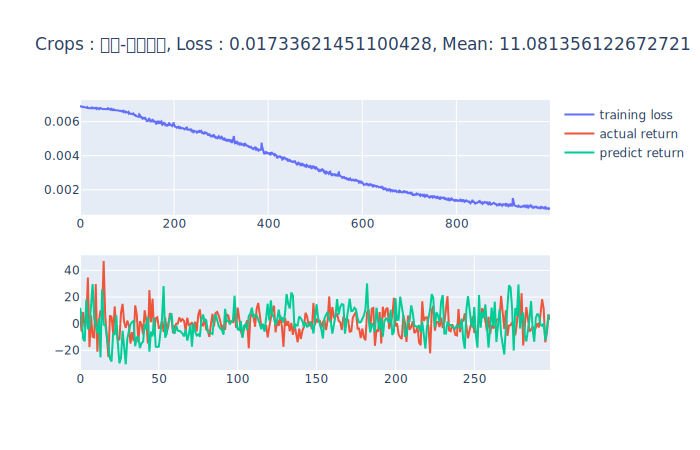

feature selection : Index(['Month', '1_day_return', '交易量', 'C0A530_StnPres', 'C0A530_WS',
       '467420_StnPres', '467420_Temperature', '467420_Precp',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0D560_StnPres',
       'C0D560_Precp', 'C0H950_Temperature', 'C0H950_Precp', 'C0G660_StnPres',
       'C0G660_Precp', 'C0K240_StnPres', 'C0K240_Precp', '467480_StnPres',
       '467480_Temperature', '467480_Precp', '467590_StnPres',
       '467590_Temperature', '467080_StnPres'],
      dtype='object')


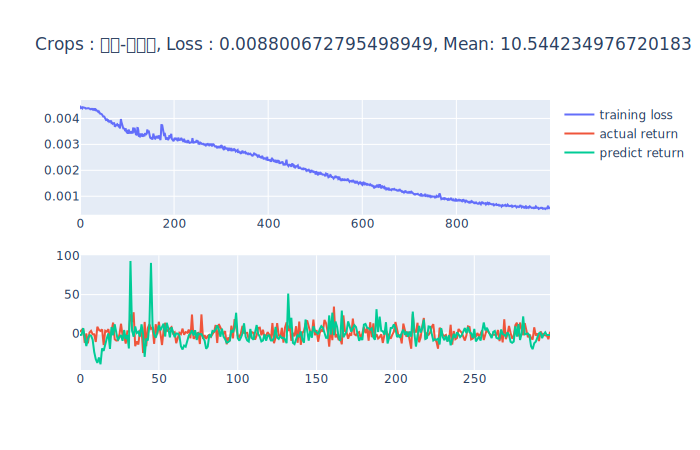

feature selection : Index(['1_day_return', 'Month', '平均價', '467490_StnPres', '467490_Temperature',
       '467420_StnPres', '467420_Precp', 'C0C590_StnPres',
       'C0C590_Temperature', 'C0C590_WS', 'C0C590_Precp', 'C0D560_StnPres',
       'C0D560_Temperature', 'C0D560_Precp', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0H950_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0G660_Precp', 'C0K240_StnPres',
       'C0K240_Temperature', 'C0K240_Precp', '467480_WS', '467590_StnPres',
       '467590_Temperature', '467590_WS', '467590_Precp', '467660_StnPres'],
      dtype='object')


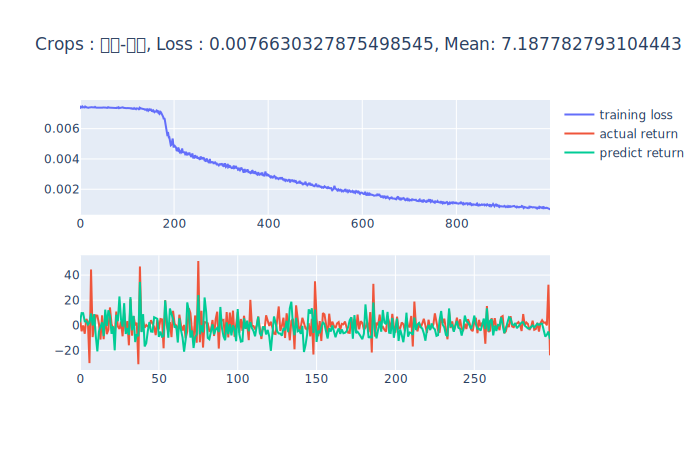

feature selection : Index(['1_day_return', 'Month', 'C0A530_StnPres', 'C0A530_Precp',
       '467490_StnPres', '467490_Temperature', '467420_Precp', '467440_WS',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0D560_Temperature',
       'C0D560_WS', 'C0E750_StnPres', 'C0G660_StnPres', 'C0G660_Temperature',
       'C0G660_WS', 'C0G660_Precp', '467480_StnPres', '467480_Precp',
       '467590_StnPres', '467590_Temperature', '467590_WS', '467590_Precp',
       '467080_StnPres', 'C0Z061_StnPres', 'C0Z061_Temperature'],
      dtype='object')


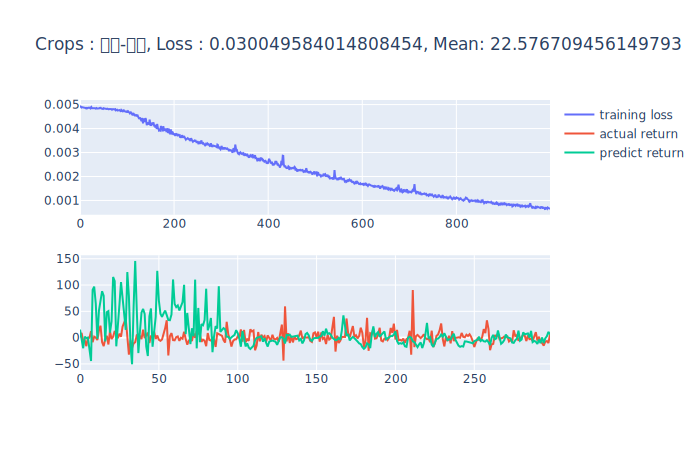

feature selection : Index(['Month', '1_day_return', 'C0A530_StnPres', 'C0A530_WS', 'C0A530_Precp',
       '467490_Temperature', '467420_Precp', '467440_WS', 'C0C590_StnPres',
       'C0E750_StnPres', 'C0H950_StnPres', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp', 'C0K240_StnPres',
       'C0K240_Temperature', '467480_Precp', '467590_StnPres',
       '467590_Temperature', '467590_WS', 'C0Z061_StnPres',
       'C0Z061_Temperature', 'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


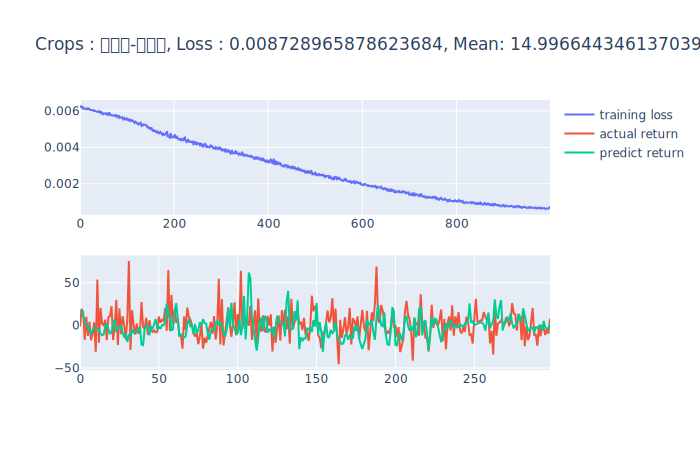

feature selection : Index(['1_day_return', 'Month', '467490_StnPres', '467490_Temperature',
       '467420_StnPres', '467420_Precp', 'C0C590_StnPres', 'C0D560_StnPres',
       'C0D560_Temperature', 'C0E750_StnPres', 'C0E750_Temperature',
       'C0E750_Precp', 'C0H950_Temperature', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp', 'C0K240_StnPres',
       '467480_Precp', '467590_StnPres', '467080_StnPres', 'C0Z061_StnPres',
       'C0Z061_Temperature', 'C0Z061_Precp', '467660_Temperature'],
      dtype='object')


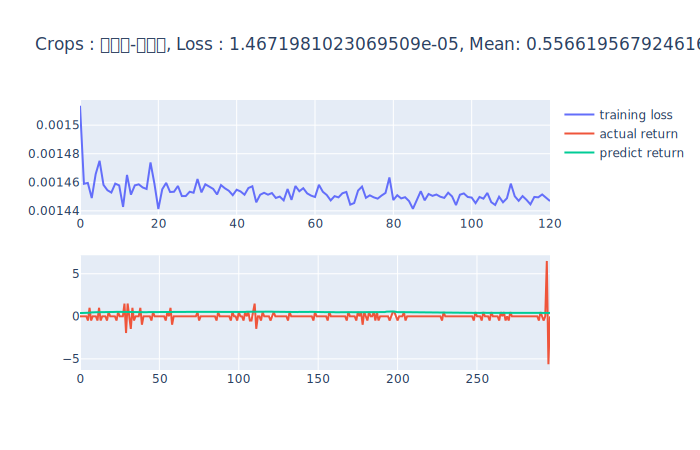

feature selection : Index(['1_day_return', 'Month', '交易量', 'C0A530_StnPres', '467490_StnPres',
       '467440_Temperature', 'C0C590_StnPres', 'C0C590_Precp',
       'C0D560_Temperature', 'C0D560_WS', 'C0E750_StnPres', 'C0E750_Precp',
       'C0H950_StnPres', 'C0H950_Precp', 'C0G660_StnPres',
       'C0G660_Temperature', 'C0K240_Temperature', 'C0K240_Precp',
       '467480_StnPres', '467480_WS', '467480_Precp', '467590_StnPres',
       '467590_WS', '467590_Precp', '467080_StnPres', '467080_WS',
       'C0Z061_StnPres', '467660_StnPres'],
      dtype='object')


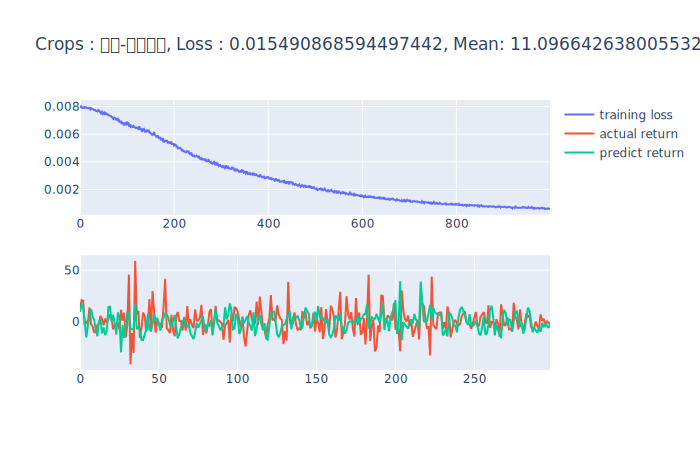

In [10]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day", "3_day_return", "5_day_return"])
    df = get_important_feature(df, split_boundary - 8, "1_day_return")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list = train(df, crops, split_boundary - 8, "1_day_return")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_1_day_return_fs.csv".format(crops), index=False, encoding="utf_8_sig")

### 3 days return

feature selection : Index(['3_day_return', 'Month', '平均價', 'C0A530_WS', '467490_Temperature',
       '467490_WS', '467420_StnPres', '467420_Precp', '467440_StnPres',
       'C0D560_StnPres', 'C0E750_StnPres', 'C0E750_Temperature',
       'C0E750_Precp', 'C0G660_Temperature', 'C0G660_WS', 'C0K240_StnPres',
       'C0K240_Temperature', 'C0K240_Precp', '467480_StnPres',
       '467480_Temperature', '467480_Precp', '467590_StnPres', '467590_Precp',
       '467080_StnPres', '467080_Precp', 'C0Z061_Temperature', 'C0Z061_Precp',
       '467660_StnPres'],
      dtype='object')


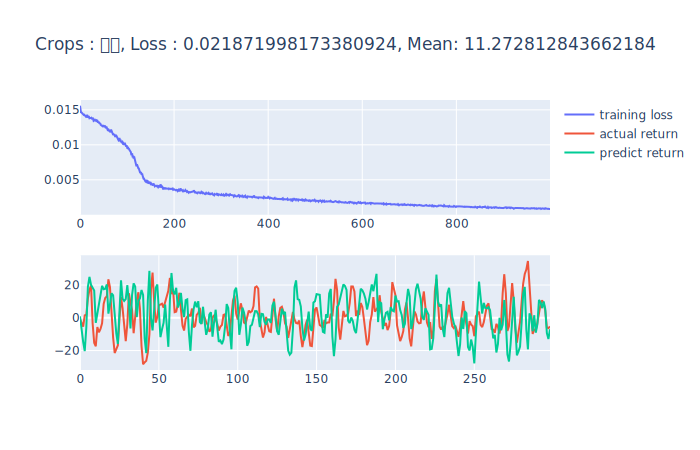

feature selection : Index(['3_day_return', 'Month', 'C0A530_Temperature', 'C0A530_Precp',
       '467490_Temperature', '467420_StnPres', '467420_Precp',
       '467440_Temperature', 'C0C590_StnPres', 'C0D560_StnPres',
       'C0D560_Precp', 'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_Precp',
       'C0G660_StnPres', 'C0K240_Precp', '467480_StnPres', '467480_Precp',
       '467590_StnPres', '467590_Temperature', '467590_WS', '467590_Precp',
       '467080_StnPres', 'C0Z061_Temperature', 'C0Z061_Precp'],
      dtype='object')


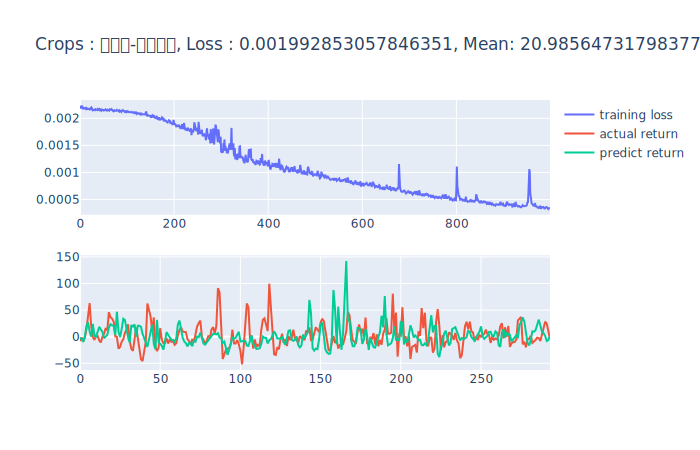

feature selection : Index(['平均價', '3_day_return', 'C0A530_StnPres', 'C0A530_Precp',
       '467490_StnPres', '467490_Temperature', '467420_StnPres',
       '467420_Temperature', '467440_StnPres', '467440_WS', 'C0C590_StnPres',
       'C0D560_StnPres', 'C0D560_Temperature', 'C0D560_WS', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_StnPres',
       'C0G660_StnPres', 'C0G660_Temperature', 'C0K240_Temperature',
       '467480_StnPres', '467480_Temperature', '467590_StnPres', '467590_WS',
       '467080_StnPres', '467080_WSGust', 'C0Z061_Temperature'],
      dtype='object')


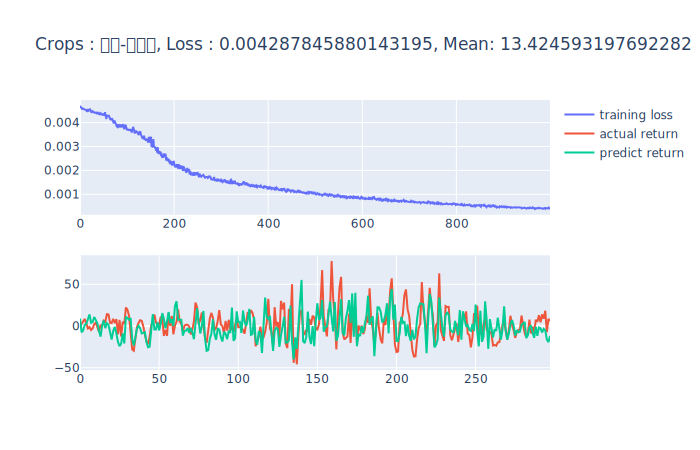

feature selection : Index(['Month', '平均價', '3_day_return', '交易量', '467490_StnPres',
       '467490_Temperature', '467420_Precp', '467440_StnPres',
       'C0C590_StnPres', 'C0D560_StnPres', 'C0D560_Temperature', 'C0D560_WS',
       'C0D560_Precp', 'C0E750_StnPres', 'C0E750_Temperature',
       'C0G660_StnPres', 'C0G660_WS', '467480_WS', '467480_Precp',
       '467590_Temperature', '467080_StnPres', 'C0Z061_Temperature',
       'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


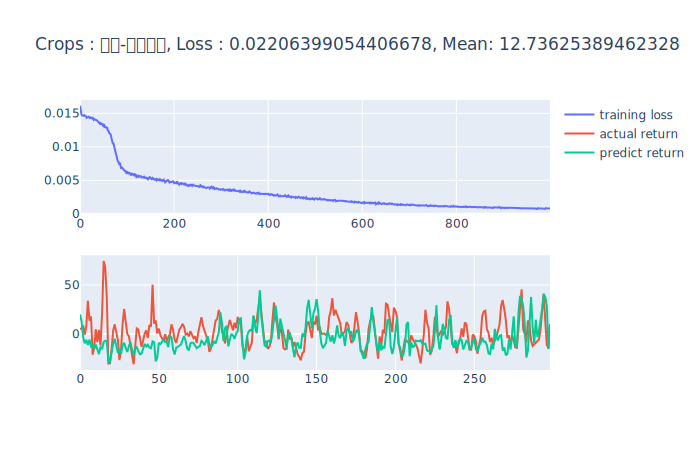

feature selection : Index(['Month', '平均價', '3_day_return', 'C0A530_StnPres', '467420_StnPres',
       '467440_StnPres', 'C0C590_StnPres', 'C0C590_Temperature',
       'C0D560_Precp', 'C0E750_StnPres', 'C0E750_Temperature',
       'C0G660_Temperature', 'C0G660_WS', 'C0K240_StnPres',
       'C0K240_Temperature', 'C0K240_Precp', '467480_StnPres',
       '467590_StnPres', '467590_Temperature', '467590_WS', '467080_StnPres',
       'C0Z061_StnPres', 'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


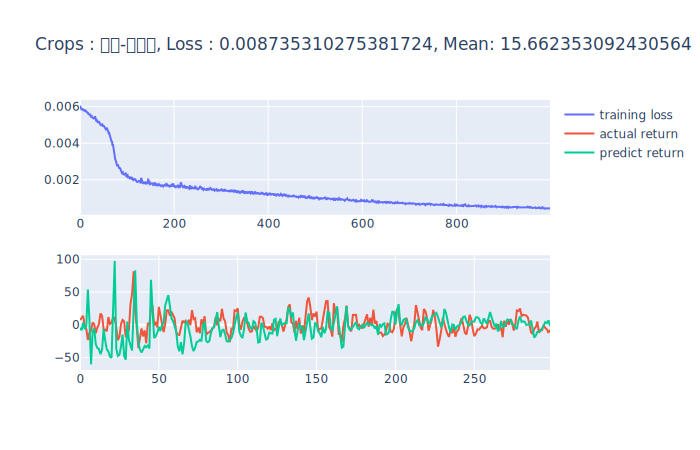

feature selection : Index(['3_day_return', 'Month', '交易量', 'C0A530_StnPres', '467490_StnPres',
       '467490_Temperature', 'C0C590_StnPres', 'C0C590_Precp',
       'C0D560_StnPres', 'C0D560_Temperature', 'C0D560_WS', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0E750_Precp', 'C0H950_Temperature',
       'C0H950_Precp', 'C0G660_WS', 'C0G660_Precp', 'C0K240_StnPres',
       'C0K240_Precp', '467480_Precp', '467590_StnPres', '467590_Temperature',
       'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


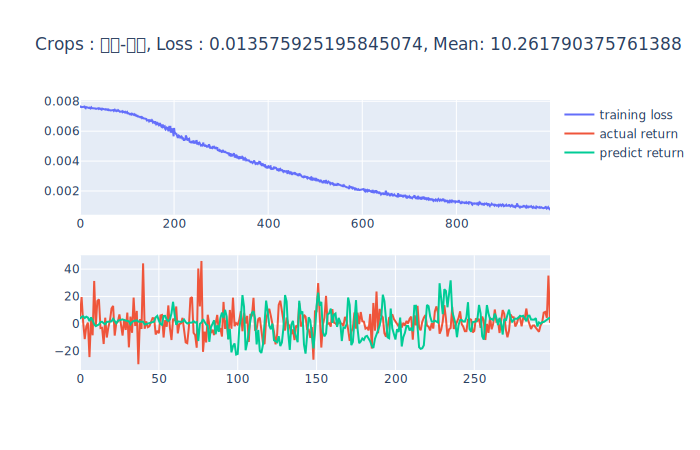

feature selection : Index(['Month', '3_day_return', '467490_StnPres', '467420_StnPres',
       '467420_WS', '467440_StnPres', '467440_WS', 'C0C590_Temperature',
       'C0D560_StnPres', 'C0D560_WS', 'C0D560_Precp', 'C0E750_StnPres',
       'C0E750_WS', 'C0H950_Precp', 'C0G660_Temperature', 'C0K240_StnPres',
       'C0K240_Precp', '467590_StnPres', '467590_WS', '467590_Precp',
       '467080_StnPres', 'C0Z061_StnPres', 'C0Z061_Precp', '467660_StnPres',
       '467660_WS'],
      dtype='object')


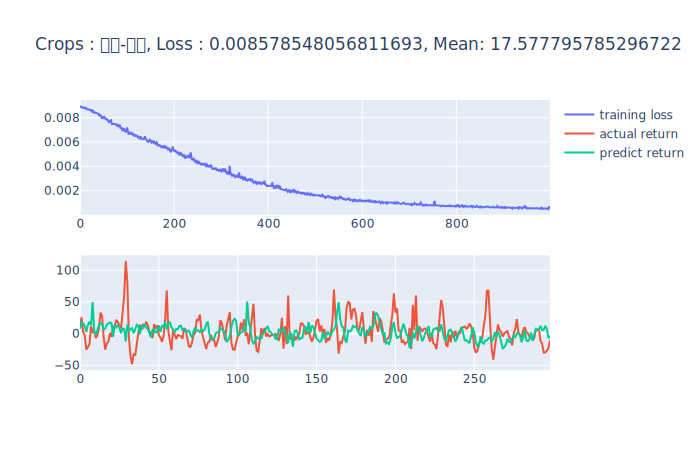

feature selection : Index(['Month', '平均價', '3_day_return', 'C0A530_StnPres', 'C0A530_Precp',
       '467490_StnPres', '467490_Temperature', '467490_WS', '467420_StnPres',
       '467420_Precp', 'C0C590_Precp', 'C0D560_WS', 'C0D560_Precp',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0H950_StnPres',
       'C0G660_Temperature', 'C0G660_WS', 'C0G660_Precp', 'C0K240_Precp',
       '467480_Precp', '467590_StnPres', 'C0Z061_StnPres',
       'C0Z061_Temperature', 'C0Z061_Precp', '467660_StnPres'],
      dtype='object')


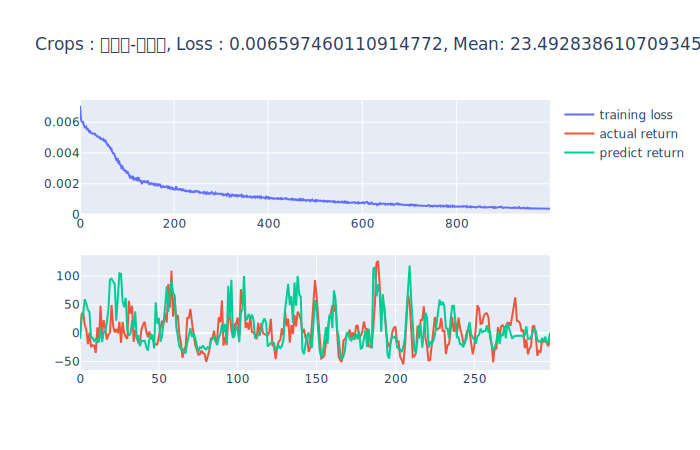

feature selection : Index(['3_day_return', 'Month', '交易量', 'C0A530_StnPres', 'C0A530_Temperature',
       'C0A530_Precp', '467490_Temperature', '467420_StnPres', '467420_Precp',
       'C0C590_StnPres', 'C0C590_WS', 'C0C590_Precp', 'C0D560_StnPres',
       'C0E750_StnPres', 'C0E750_Temperature', 'C0E750_Precp',
       'C0H950_StnPres', 'C0G660_Temperature', 'C0K240_StnPres',
       '467480_StnPres', '467480_Temperature', '467480_WS', '467480_Precp',
       '467590_StnPres', '467590_Temperature', 'C0Z061_StnPres',
       '467660_StnPres', '467660_Temperature'],
      dtype='object')


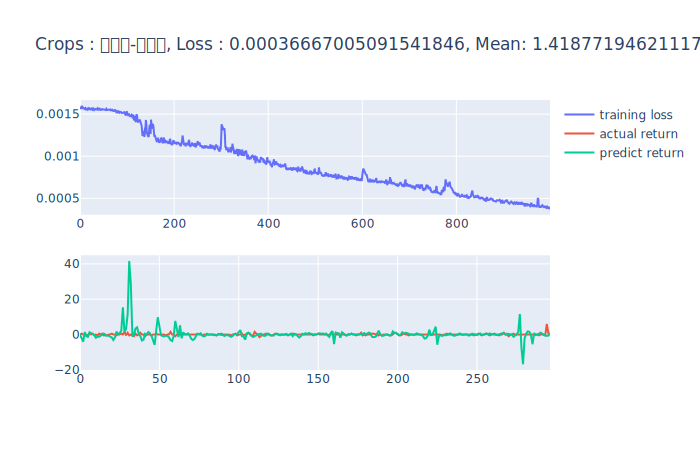

feature selection : Index(['3_day_return', 'Month', '平均價', 'C0A530_StnPres', '467490_StnPres',
       '467420_StnPres', '467420_Temperature', '467420_Precp',
       'C0C590_StnPres', 'C0C590_Temperature', 'C0C590_Precp',
       'C0D560_StnPres', 'C0D560_Precp', 'C0E750_StnPres',
       'C0E750_Temperature', 'C0G660_Temperature', 'C0G660_WS',
       'C0K240_StnPres', 'C0K240_Precp', '467480_StnPres',
       '467480_Temperature', '467480_Precp', '467590_StnPres',
       '467590_Temperature', '467080_StnPres', '467660_StnPres'],
      dtype='object')


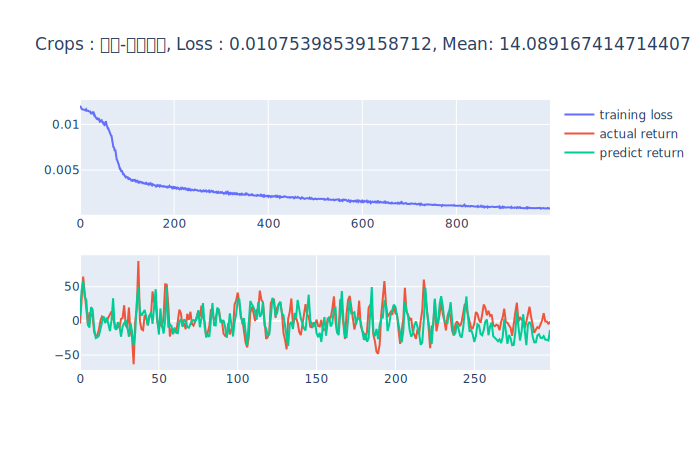

In [11]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    DateTime_arr = df["DateTime"][split_boundary:]
    df = df.drop(columns=["DateTime", "Year", "Day", "1_day_return", "5_day_return"])
    df = get_important_feature(df, split_boundary - 8, "3_day_return")
    print("feature selection :", df.columns)
    test_y_list, predict_y_list = train(df, crops, split_boundary - 8, "3_day_return")
    data = {
        "DateTime": DateTime_arr,
        "Original": test_y_list,
        "Predict": predict_y_list,
    }
    df = pd.DataFrame(data)
    df.to_csv("{}_3_day_return_fs.csv".format(crops), index=False, encoding="utf_8_sig")